In [1]:
!nvidia-smi

Tue Feb  3 16:10:02 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.211.01             Driver Version: 570.211.01     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   35C    P8              2W /   55W |     687MiB /   8188MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# ==== Basic imports ====
import os
import sys
import time
import math
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# ==== Reproducibility ====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# ==== Device check ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ==== CUDA details ====
if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name())
    print("CUDA Capability:", torch.cuda.get_device_capability(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("⚠️ CUDA not available")


Device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Capability: (8, 9)
CUDA Version: 12.1


In [3]:
DATASET_ROOT = Path("/home/vector/master_dataset")

assert DATASET_ROOT.exists(), "Dataset path does not exist"
print("Dataset root:", DATASET_ROOT)

classes = sorted([d.name for d in DATASET_ROOT.iterdir() if d.is_dir()])
print("Classes:", classes)
print("Num classes:", len(classes))


Dataset root: /home/vector/master_dataset
Classes: ['e_waste', 'glass', 'medical', 'metal', 'organic', 'paper_cardboard', 'plastic', 'textile']
Num classes: 8


# Dataset generator

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

IMAGE_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 4

# ---- Transforms ----

# Performing data augmentation && normalization
train_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ---- Load full dataset ONCE ----
full_ds = datasets.ImageFolder(
    root=DATASET_ROOT,
    transform=train_tfms
)

print("Total images:", len(full_ds))
print("Class to index:", full_ds.class_to_idx)

# ---- Split dataset into train and Val sets  ----
VAL_RATIO = 0.15
val_size = int(len(full_ds) * VAL_RATIO)
train_size = len(full_ds) - val_size

# Split and shuffle
train_base, val_base = random_split(
    full_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# ---- Assign correct transforms ----
train_base.dataset.transform = train_tfms
val_base.dataset.transform   = val_tfms


/home/vector/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Disabling PyTorch because PyTorch >= 2.2 is required but found 2.1.2+cu121
PyTorch was not found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Total images: 41423
Class to index: {'e_waste': 0, 'glass': 1, 'medical': 2, 'metal': 3, 'organic': 4, 'paper_cardboard': 5, 'plastic': 6, 'textile': 7}


In [ ]:
class MultiHotWrapper(torch.utils.data.Dataset):
    def __init__(self, imagefolder_ds, num_classes):
        self.ds = imagefolder_ds
        self.num_classes = num_classes

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        target = torch.zeros(self.num_classes)
        target[label] = 1.0
        return img, target

# convert (img : int) -> img:[0,1,0,0,0, .... ]
train_ds = MultiHotWrapper(train_base, num_classes=8)
val_ds   = MultiHotWrapper(val_base,   num_classes=8)

In [6]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


In [7]:
imgs, targets = next(iter(train_loader))

print("Image batch shape :", imgs.shape)
print("Target batch shape:", targets.shape)
print("Sample targets:\n", targets[:5])
print("Targets sum (should be 1 each):", targets.sum(dim=1)[:5])


Image batch shape : torch.Size([64, 3, 224, 224])
Target batch shape: torch.Size([64, 8])
Sample targets:
 tensor([[0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.]])
Targets sum (should be 1 each): tensor([1., 1., 1., 1., 1.])


/home/vector/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


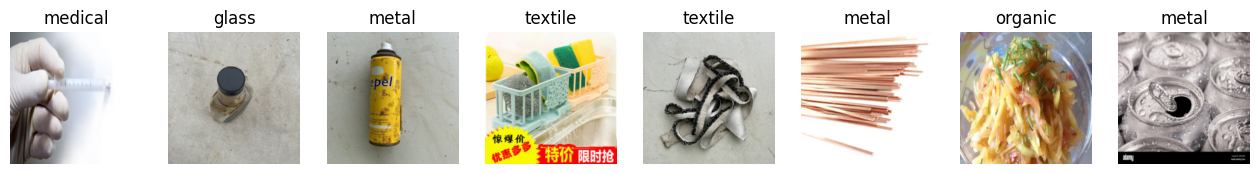

In [ ]:
import matplotlib.pyplot as plt

# class index → name
idx_to_class = {v: k for k, v in full_ds.class_to_idx.items()}

def show_batch(images, targets, n=8):
    images = images[:n]
    targets = targets[:n]

    # unnormalize for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    images = images * std + mean
    images = images.clamp(0, 1)

    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].permute(1,2,0))
        label_idx = targets[i].argmax().item()
        plt.title(idx_to_class[label_idx])
        plt.axis("off")
    plt.show()

imgs, targets = next(iter(train_loader))
show_batch(imgs, targets)


In [9]:
imgs, targets = next(iter(val_loader))
print(targets.argmax(dim=1)[:20])


tensor([2, 3, 1, 1, 5, 2, 0, 6, 6, 6, 6, 3, 4, 3, 0, 2, 3, 6, 2, 6])


# Loading model

In [10]:
import timm

def create_vit_model(model_name="vit_base_patch16_224",num_classes=8,pretrained=True):
    model = timm.create_model( model_name, pretrained=pretrained, num_classes=num_classes)
    return model


In [12]:
model = create_vit_model( model_name="vit_base_patch16_224", num_classes=8, pretrained=True)
model = model.to(device)

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
VisionTransformer                        152,064
├─PatchEmbed: 1-1                        --
│    └─Conv2d: 2-1                       590,592
│    └─Identity: 2-2                     --
├─Dropout: 1-2                           --
├─Identity: 1-3                          --
├─Identity: 1-4                          --
├─Sequential: 1-5                        --
│    └─Block: 2-3                        --
│    │    └─LayerNorm: 3-1               1,536
│    │    └─Attention: 3-2               2,362,368
│    │    └─Identity: 3-3                --
│    │    └─Identity: 3-4                --
│    │    └─LayerNorm: 3-5               1,536
│    │    └─Mlp: 3-6                     4,722,432
│    │    └─Identity: 3-7                --
│    │    └─Identity: 3-8                --
│    └─Block: 2-4                        --
│    │    └─LayerNorm: 3-9               1,536
│    │    └─Attention: 3-10              2,362,368
│    │    └─Identity: 3-11     

In [13]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total, trainable = count_params(model)
print(f"Total params     : {total/1e6:.2f} M")
print(f"Trainable params : {trainable/1e6:.2f} M")


Total params     : 85.80 M
Trainable params : 85.80 M


In [14]:
model.eval()
with torch.no_grad():
    x, y = next(iter(train_loader))
    x = x.to(device)
    out = model(x)

print("Output shape:", out.shape)


/home/vector/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Output shape: torch.Size([64, 8])


## Training
### Phase 1

In [15]:
import torch.nn as nn
from torch import optim
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm

# ===== Loss (multi-label) =====
criterion = nn.BCEWithLogitsLoss()

# ===== Optimizer =====
optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

# ===== Scheduler (optional but recommended) =====
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10
)

# ===== AMP scaler =====
scaler = GradScaler()


In [16]:
def multilabel_accuracy(logits, targets, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    correct = (preds == targets).float().mean()
    return correct.item()

def micro_f1(logits, targets, threshold=0.5, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

    tp = (preds * targets).sum()
    fp = (preds * (1 - targets)).sum()
    fn = ((1 - preds) * targets).sum()

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)

    f1 = 2 * precision * recall / (precision + recall + eps)
    return f1.item()


In [17]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    running_acc  = 0.0
    running_f1   = 0.0

    pbar = tqdm(loader, desc="Train", leave=False)

    for imgs, targets in pbar:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = multilabel_accuracy(outputs, targets)
        f1  = micro_f1(outputs, targets)

        running_loss += loss.item()
        running_acc  += acc
        running_f1   += f1

        pbar.set_postfix(
            loss=f"{loss.item():.4f}",
            acc=f"{acc:.4f}",
            f1=f"{f1:.4f}"
        )

    n = len(loader)
    return (
        running_loss / n,
        running_acc / n,
        running_f1 / n
    )


In [18]:
@torch.no_grad()
def validate_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    running_acc  = 0.0
    running_f1   = 0.0

    pbar = tqdm(loader, desc="Val", leave=False)

    for imgs, targets in pbar:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        outputs = model(imgs)
        loss = criterion(outputs, targets)

        acc = multilabel_accuracy(outputs, targets)
        f1  = micro_f1(outputs, targets)

        running_loss += loss.item()
        running_acc  += acc
        running_f1   += f1

        pbar.set_postfix(
            val_loss=f"{loss.item():.4f}",
            val_acc=f"{acc:.4f}",
            val_f1=f"{f1:.4f}"
        )

    n = len(loader)
    return (
        running_loss / n,
        running_acc / n,
        running_f1 / n
    )


In [19]:
import warnings
from PIL import Image

# Suppress specific PIL transparency warning
warnings.filterwarnings(
    "ignore",
    # message="Palette images with Transparency expressed in bytes"
)

# Force PIL to always convert images to RGB
Image.MAX_IMAGE_PIXELS = None


In [20]:
EPOCHS = 10
SAVE_DIR = Path("checkpoints_vit_phase1")
SAVE_DIR.mkdir(exist_ok=True)

history = {
    "train_loss": [],
    "train_acc": [],
    "train_f1": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": []
}

best_val_f1 = 0.0

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader)
    val_loss, val_acc, val_f1       = validate_one_epoch(model, val_loader)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_f1"].append(train_f1)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    print(
        f"Train | loss {train_loss:.4f} | acc {train_acc:.4f} | f1 {train_f1:.4f}\n"
        f"Val   | loss {val_loss:.4f} | acc {val_acc:.4f} | f1 {val_f1:.4f}"
    )

    # ===== Save last =====
    torch.save(
        {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scaler_state": scaler.state_dict(),
            "history": history
        },
        SAVE_DIR / "last.pt"
    )

    # ===== Save best =====
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "best_val_f1": best_val_f1
            },
            SAVE_DIR / "best.pt"
        )
        print("Best model saved")



Epoch 1/10


Train | loss 0.2509 | acc 0.9014 | f1 0.4486
Val   | loss 0.2058 | acc 0.9201 | f1 0.6109
Best model saved

Epoch 2/10


Train | loss 0.1714 | acc 0.9324 | f1 0.6967
Val   | loss 0.1690 | acc 0.9322 | f1 0.6888
Best model saved

Epoch 3/10


Train | loss 0.1366 | acc 0.9465 | f1 0.7693
Val   | loss 0.1659 | acc 0.9360 | f1 0.7241
Best model saved

Epoch 4/10


Train | loss 0.1071 | acc 0.9588 | f1 0.8266
Val   | loss 0.1654 | acc 0.9373 | f1 0.7321
Best model saved

Epoch 5/10


Train | loss 0.0744 | acc 0.9719 | f1 0.8847
Val   | loss 0.1532 | acc 0.9456 | f1 0.7729
Best model saved

Epoch 6/10


Train | loss 0.0433 | acc 0.9840 | f1 0.9353
Val   | loss 0.1651 | acc 0.9469 | f1 0.7827
Best model saved

Epoch 7/10


Train | loss 0.0184 | acc 0.9935 | f1 0.9741
Val   | loss 0.1902 | acc 0.9480 | f1 0.7896
Best model saved

Epoch 8/10


Train | loss 0.0058 | acc 0.9982 | f1 0.9926
Val   | loss 0.2237 | acc 0.9496 | f1 0.7974
Best model saved

Epoch 9/10


Train | loss 0.0016 | acc 0.9996 | f1 0.9983
Val   | loss 0.2474 | acc 0.9525 | f1 0.8092
Best model saved

Epoch 10/10


Train | loss 0.0003 | acc 0.9999 | f1 0.9998
Val   | loss 0.2540 | acc 0.9529 | f1 0.8109
Best model saved


# Testing

In [33]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_vit_attention(model, img_tensor, img_raw):
    """
    img_tensor: (1, 3, 224, 224) normalized
    img_raw   : (H, W, 3) unnormalized
    """
    model.eval()

    # ---- forward with attention ----
    feats, attn = model.forward_features(img_tensor, return_attention=True)
    # attn shape: (B, num_heads, tokens, tokens)

    attn = attn[0]                  # first image
    cls_attn = attn[:, 0, 1:]        # CLS → patches

    num_heads = cls_attn.shape[0]
    grid_size = int(cls_attn.shape[-1] ** 0.5)

    cls_attn = cls_attn.reshape(num_heads, grid_size, grid_size)
    cls_attn = cls_attn.mean(0)

    # upscale to image size
    cls_attn = cls_attn.unsqueeze(0).unsqueeze(0)
    cls_attn = F.interpolate(
        cls_attn, size=(224, 224), mode="bilinear", align_corners=False
    )
    cls_attn = cls_attn.squeeze().cpu().numpy()

    # normalize
    cls_attn = (cls_attn - cls_attn.min()) / (cls_attn.max() - cls_attn.min() + 1e-8)

    # plot
    plt.figure(figsize=(5, 5))
    plt.imshow(img_raw)
    plt.imshow(cls_attn, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("ViT CLS Attention (Last Layer)")
    plt.show()


In [34]:
imgs, _ = next(iter(val_loader))

img_tensor = imgs[0].unsqueeze(0).to(device)

mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
img_raw = (imgs[0] * std + mean).permute(1,2,0).clamp(0,1)

plot_vit_attention(model, img_tensor, img_raw)


TypeError: VisionTransformer.forward_features() got an unexpected keyword argument 'return_attention'

In [35]:
idx_to_class = {v: k for k, v in full_ds.class_to_idx.items()}

def decode_prediction(prob_vec, threshold=0.5):
    return {
        idx_to_class[i]: float(prob_vec[i])
        for i in range(len(prob_vec))
        if prob_vec[i] > threshold
    }

for i in range(5):
    print(f"\nSample {i}")
    print("GT :", decode_prediction(targets[i]))
    print("PR :", decode_prediction(probs[i]))



Sample 0
GT : {'organic': 1.0}


NameError: name 'probs' is not defined

In [36]:
from PIL import Image

def predict_image(model, img_path, transform, threshold=0.5):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.sigmoid(logits)[0].cpu()

    return decode_prediction(probs, threshold), probs


In [37]:
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_val_predictions_clean(
    model,
    loader,
    idx_to_class,
    n=4,
    threshold=0.5
):
    model.eval()

    imgs, targets = next(iter(loader))
    imgs = imgs.to(device)
    targets = targets.to(device)

    logits = model(imgs)
    probs = torch.sigmoid(logits)

    imgs = imgs.cpu()
    targets = targets.cpu()
    probs = probs.cpu()

    # unnormalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    imgs = (imgs * std + mean).clamp(0, 1)

    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

    for i in range(n):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # ---- IMAGE ----
        axes[0].imshow(imgs[i].permute(1,2,0))
        axes[0].axis("off")

        gt_idx = targets[i].argmax().item()
        axes[0].set_title(f"Truth: {idx_to_class[gt_idx]}", fontsize=12)

        # ---- PROB BAR PLOT ----
        axes[1].bar(class_names, probs[i])
        axes[1].axhline(threshold, linestyle="--")
        axes[1].set_ylim(0, 1)
        axes[1].set_ylabel("Probability")
        axes[1].set_title("Model confidence")

        # highlight GT bar
        axes[1].get_children()[gt_idx].set_alpha(0.9)

        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


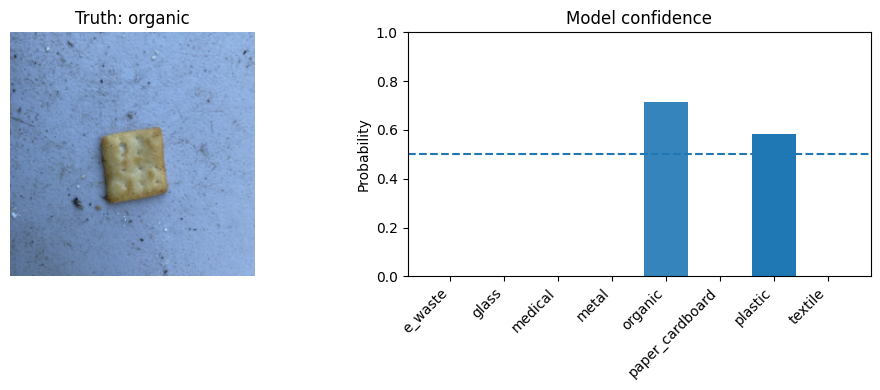

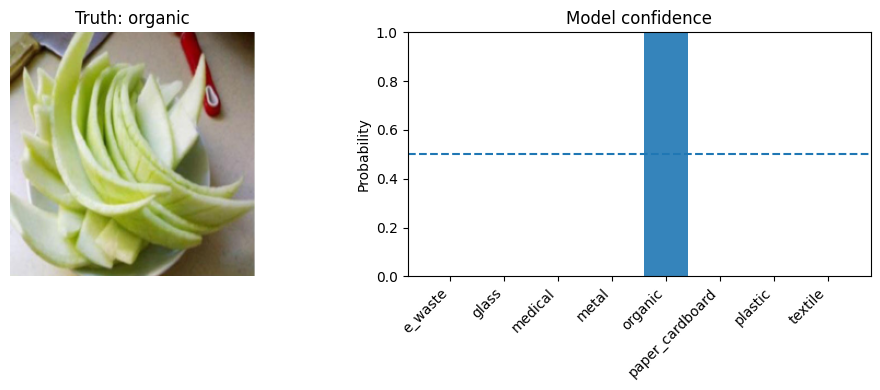

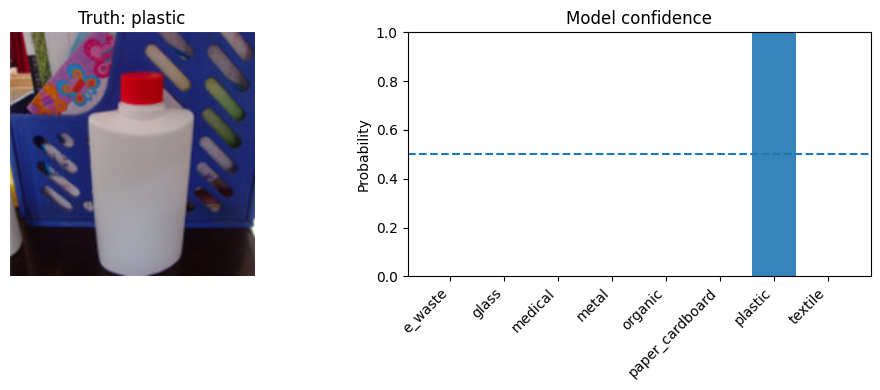

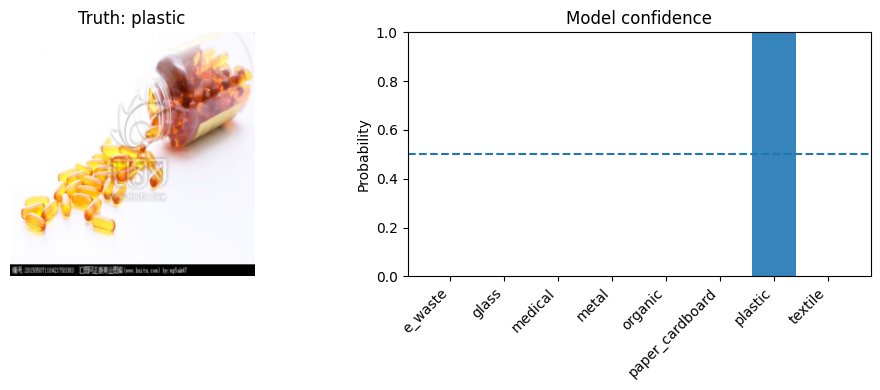

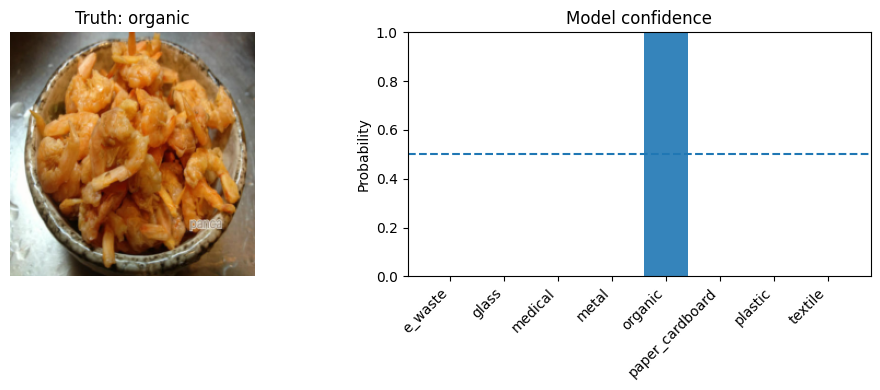

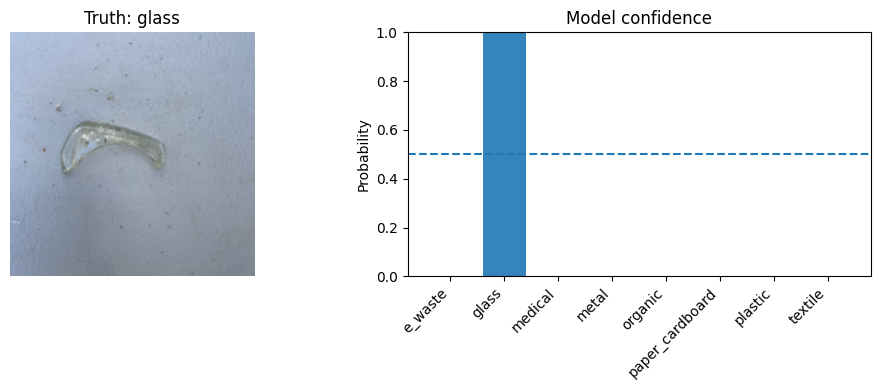

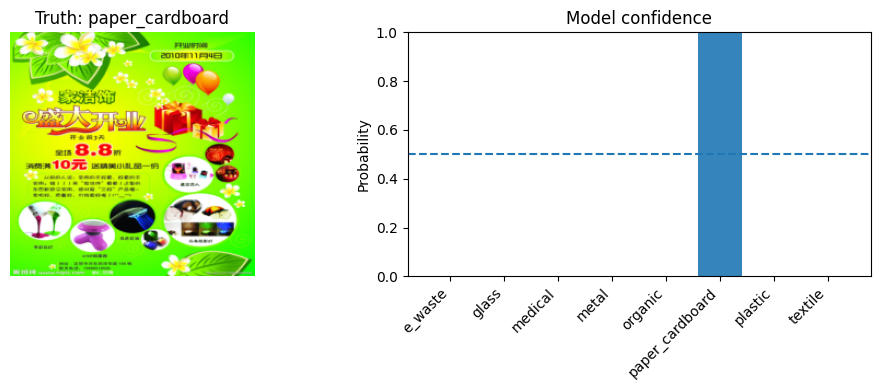

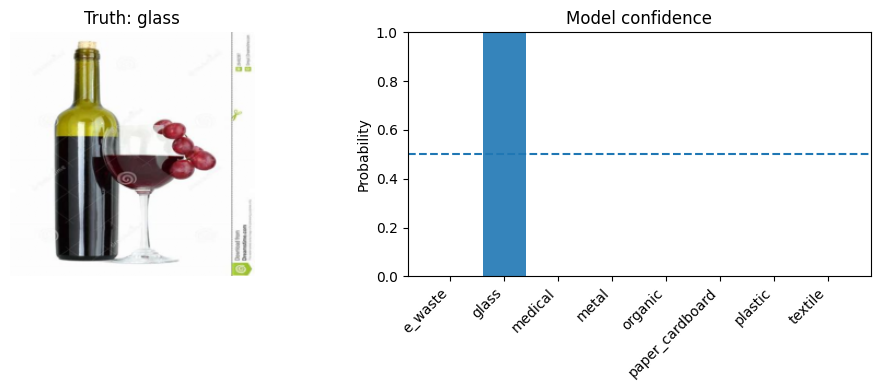

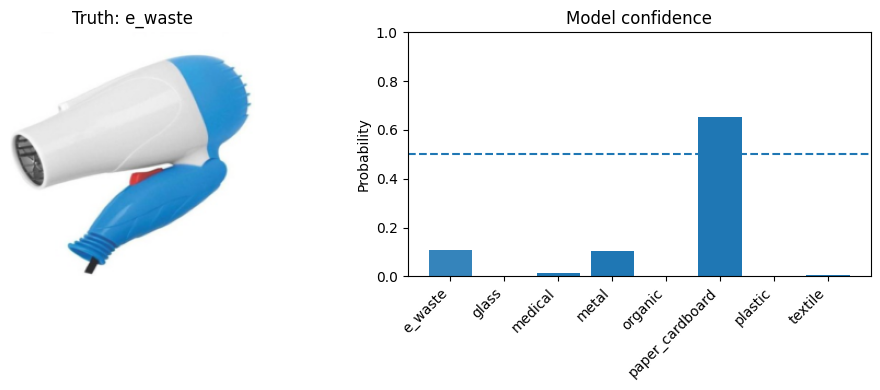

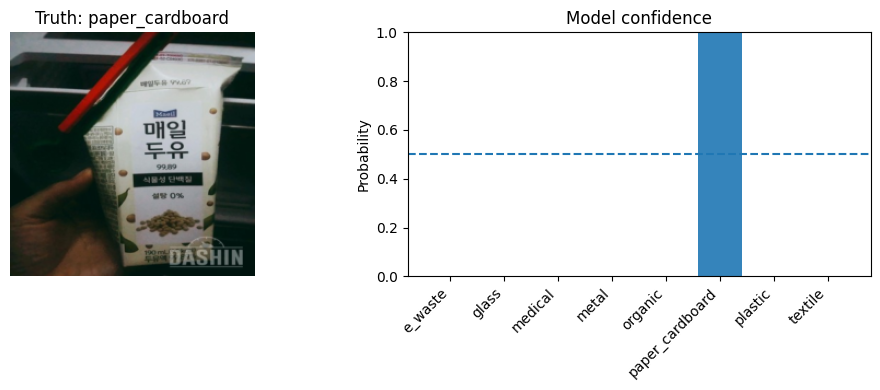

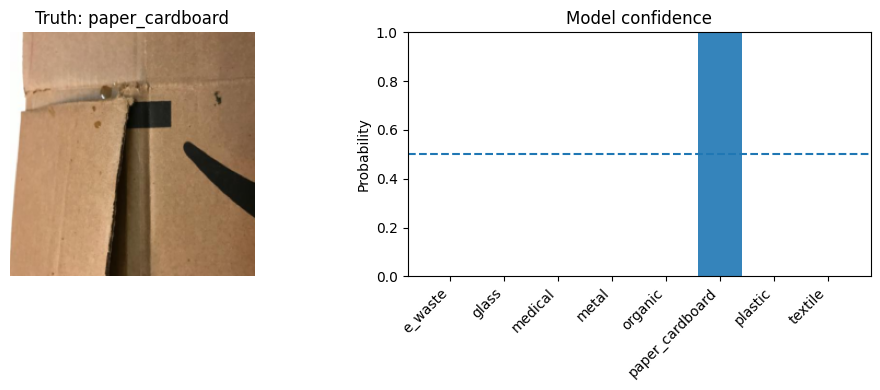

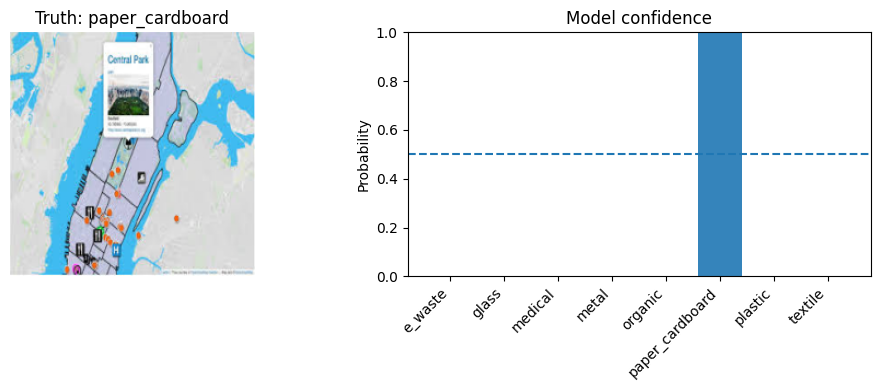

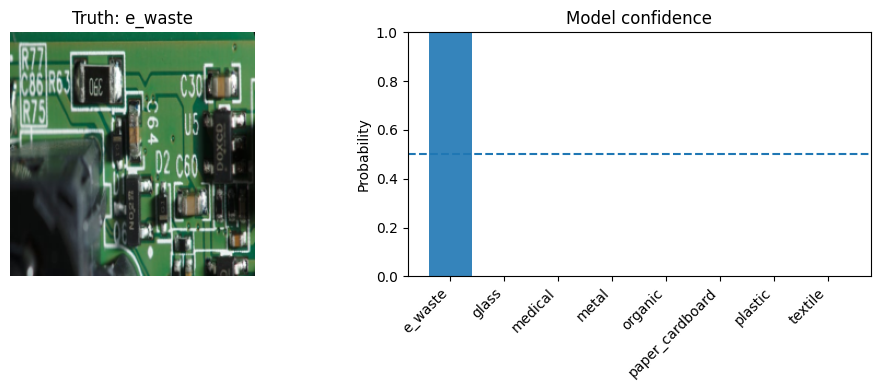

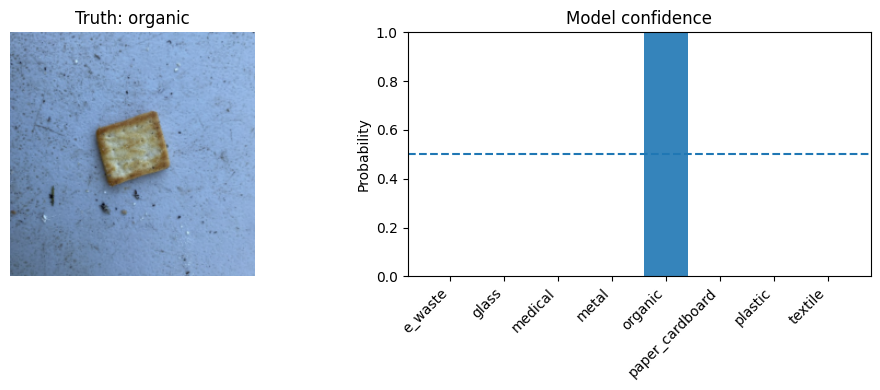

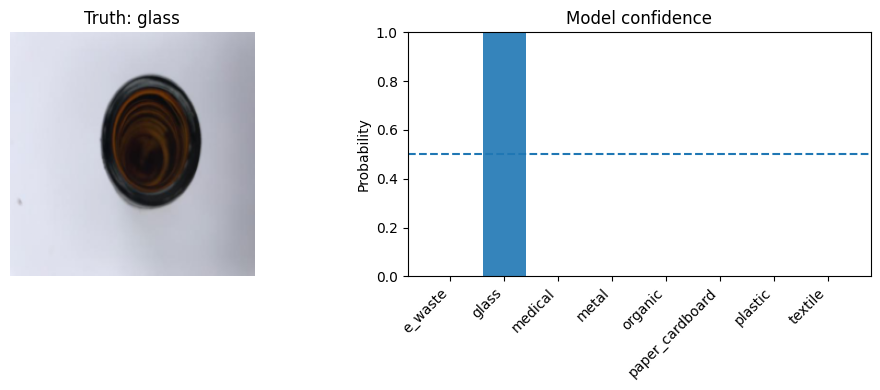

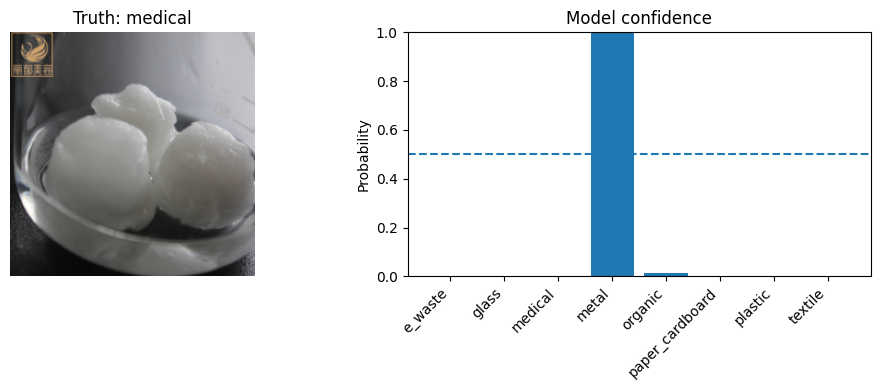

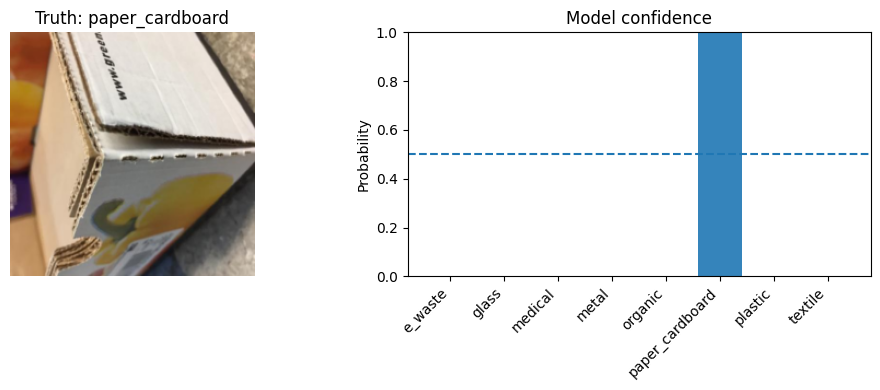

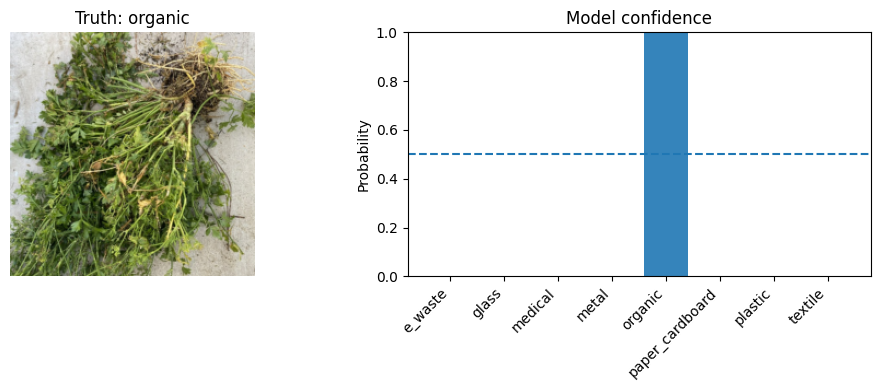

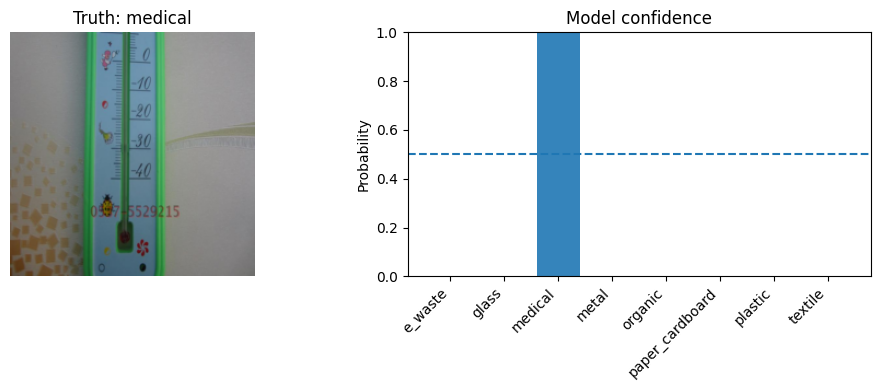

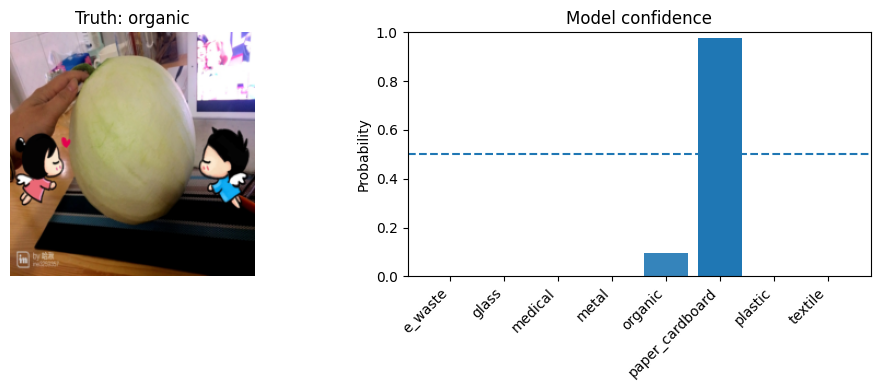

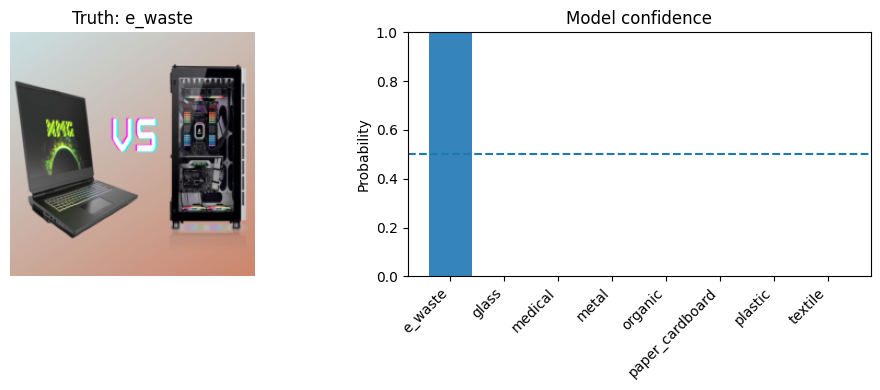

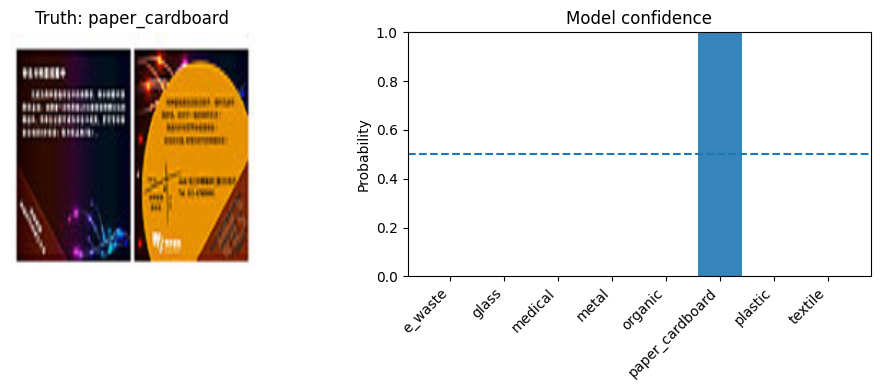

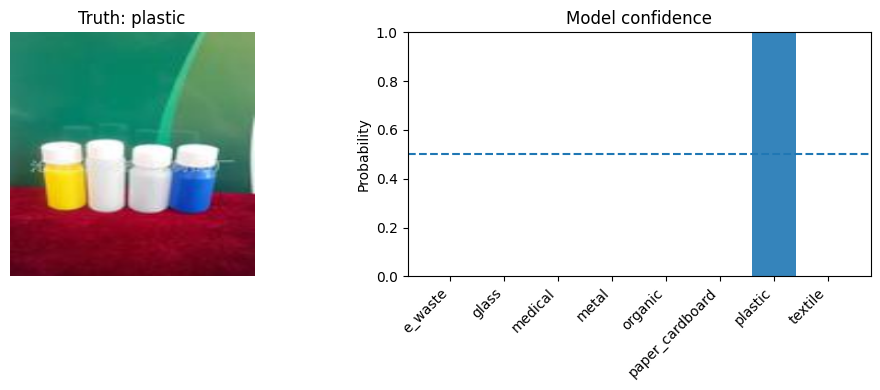

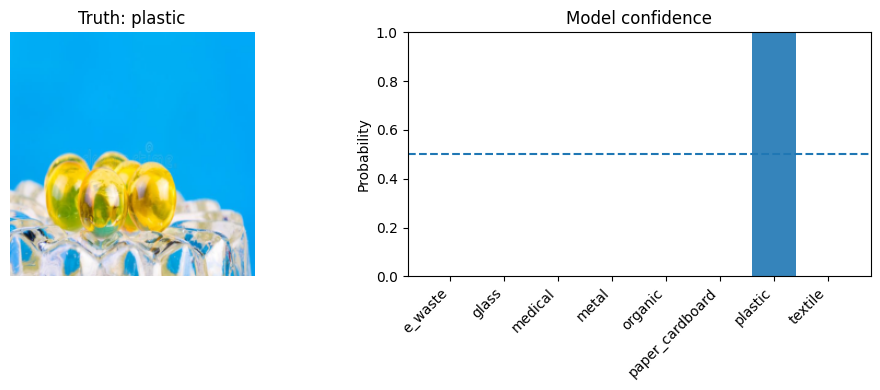

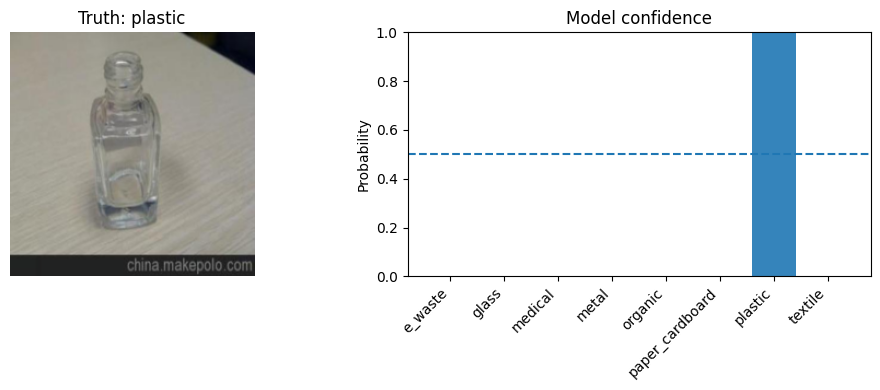

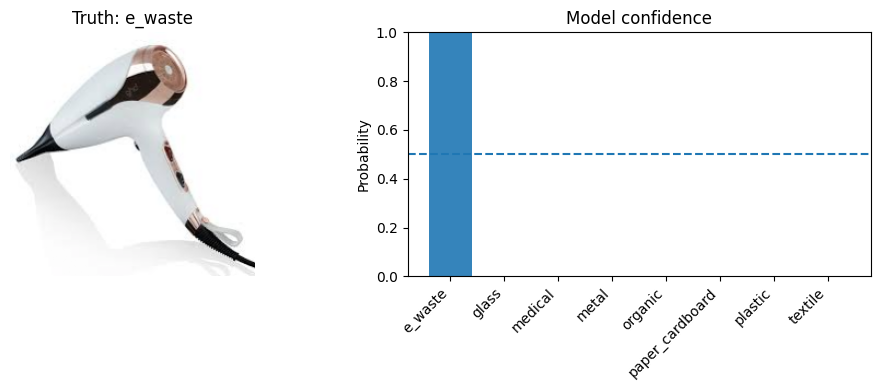

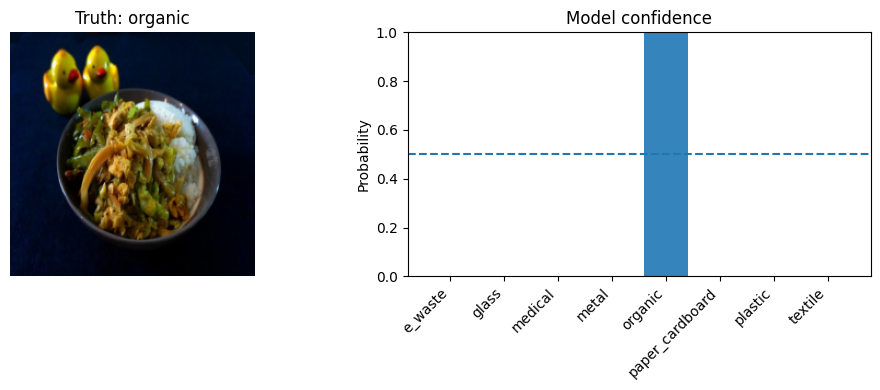

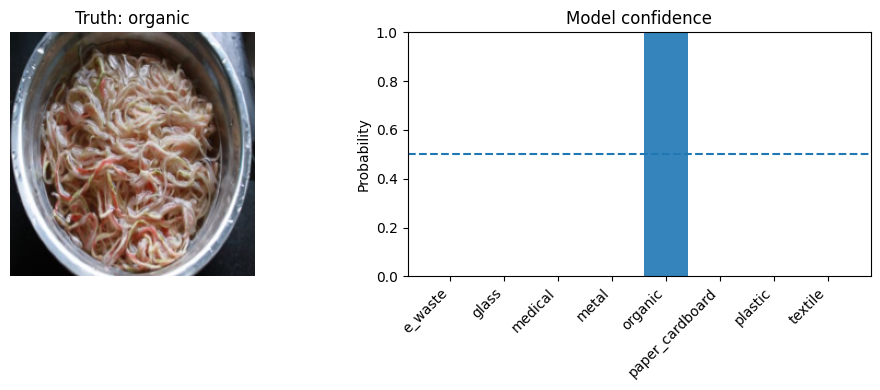

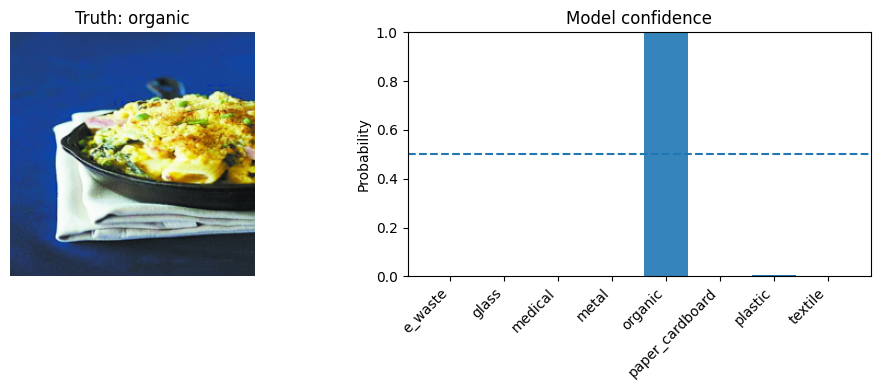

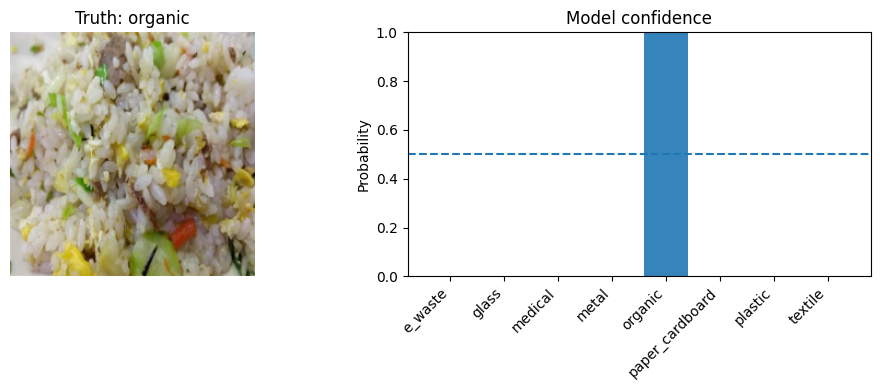

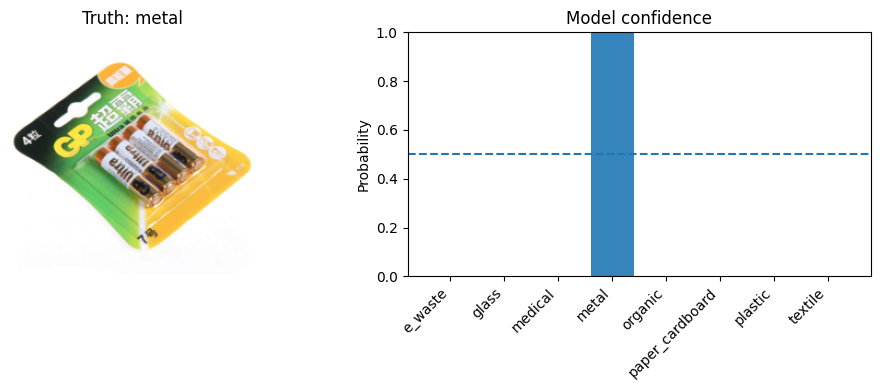

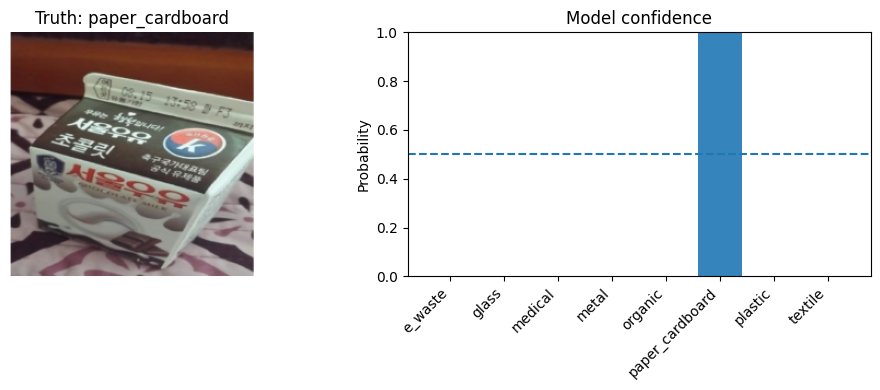

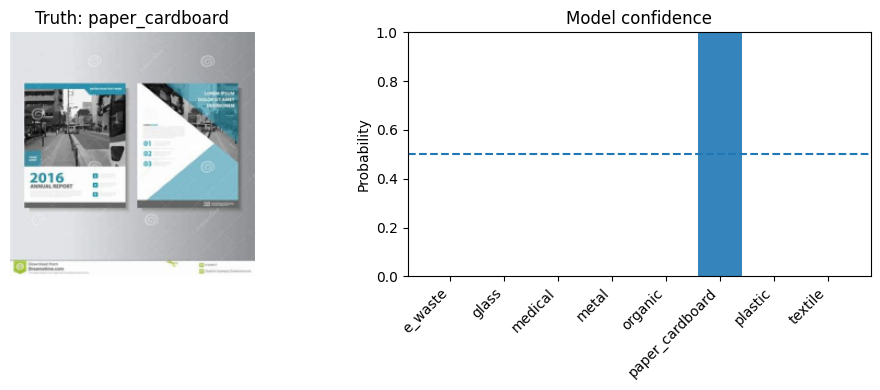

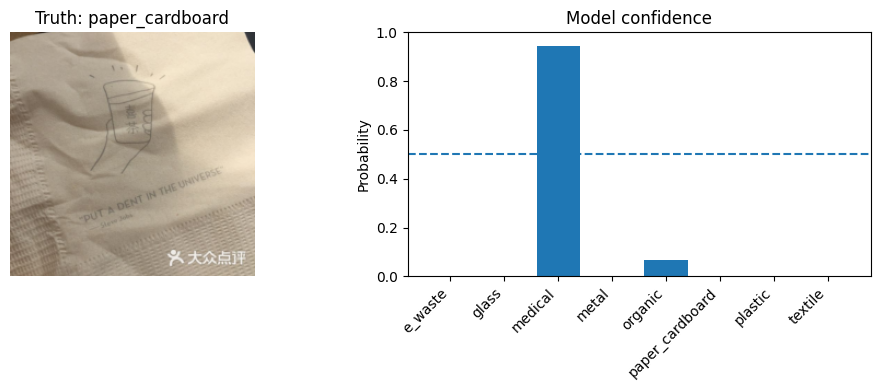

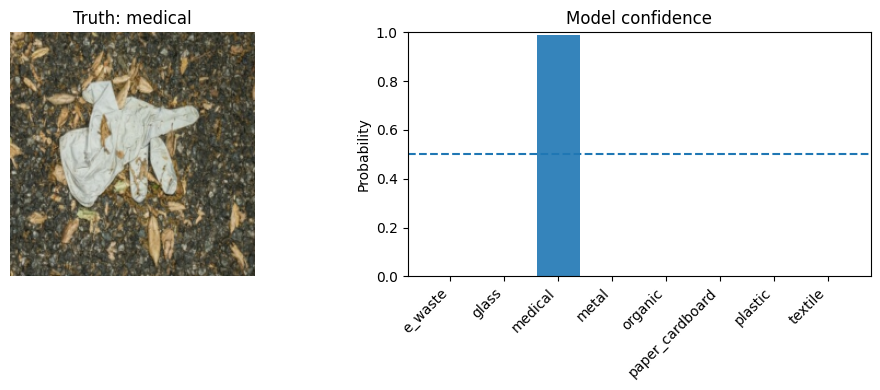

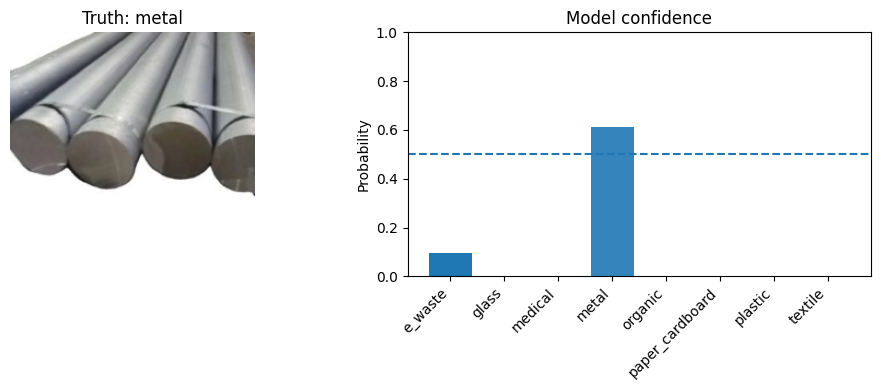

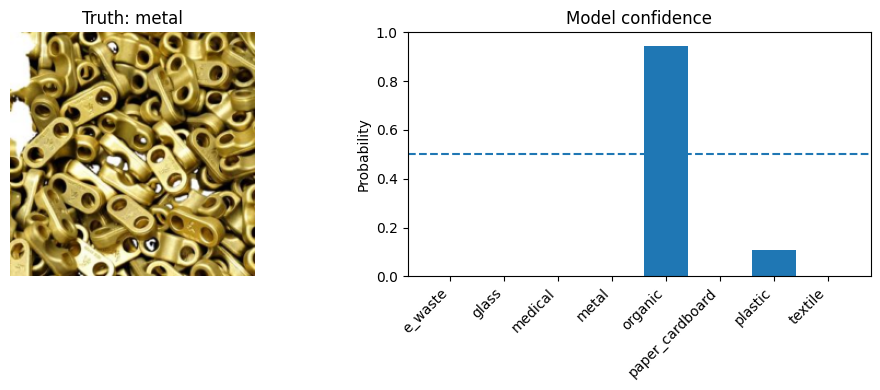

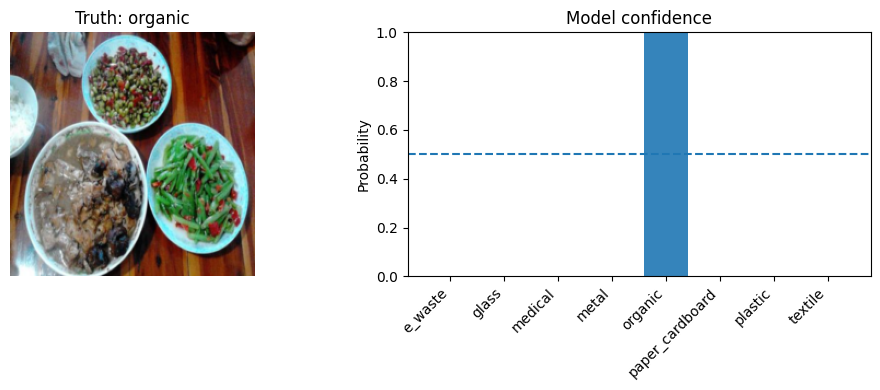

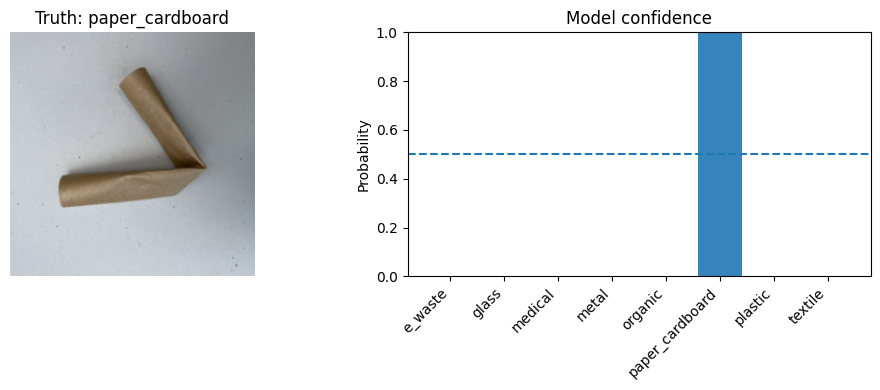

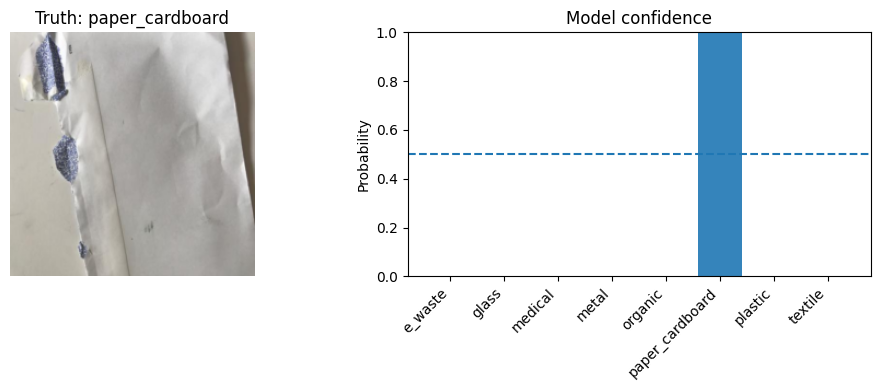

In [38]:
visualize_val_predictions_clean(
    model,
    val_loader,
    idx_to_class,
    n=40,
    threshold=0.5
)
